# Lab3 Model Quantization
## Setup
### Install python package

In [1]:
!pip install torch
!pip install torchinfo
!pip install torchsummary
!pip install torchvision
!pip install tqdm
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

### Environment Setup

In [2]:
import os
import math
import copy
import time
import torch
import platform
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.ao.quantization as tq

from enum import Enum
from tqdm import tqdm
from typing import Tuple
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

# Select device
DEFAULT_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ignore warnings in Pytorch2.8 when using torch.ao.quantization
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set quantization backend based on CPU architecture
machine = platform.machine().lower()
if "x86" in machine or "amd64" in machine:
    torch.backends.quantized.engine = 'fbgemm'
elif "arm" in machine or "aarch64" in machine:
    torch.backends.quantized.engine = 'qnnpack'
else:
    print("Unsupported machine:", machine)

# Check environment information
print("Pytorch version:", torch.__version__)
print(f"Using {torch.backends.quantized.engine} backend {machine}")
print("Using device:", DEFAULT_DEVICE)

Pytorch version: 2.5.1+cu124
Using fbgemm backend x86_64
Using device: cuda


### Load CIFAR-10 Dataset

In [4]:
def get_loaders(
    source, batch_size: int, transform, eval_transform=None,
    root: str = "data", split_ratio: float = 0.1
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    if eval_transform is None:
        eval_transform = transform

    trainset = source(root=root, train=True, download=True, transform=transform)
    testset  = source(root=root, train=False, download=True, transform=eval_transform)

    val_len = int(split_ratio * len(trainset))
    train_len = len(trainset) - val_len
    trainset, valset = torch.utils.data.random_split(trainset, [train_len, val_len])

    loader_kwargs = dict(batch_size=batch_size, num_workers=4, pin_memory=True)
    trainloader = DataLoader(trainset, shuffle=True, **loader_kwargs)
    valloader  = DataLoader(valset, shuffle=True, **loader_kwargs)
    testloader = DataLoader(testset, shuffle=False, **loader_kwargs)

    return trainloader, valloader, testloader

def get_cifar10_loaders(batch_size: int, root="data/cifar10", split_ratio: float = 0.1):
    """
    Create CIFAR-10 training / validation / testing dataloaders.
    
    Args:
        batch_size (int): Number of samples per mini-batch.
        root (str): Path to download/load CIFAR-10 dataset.
        split_ratio (float): Fraction of training set to use for validation.
    
    Returns:
        train_loader, val_loader, test_loader (torch.utils.data.DataLoader)
    """

    train_transform = transforms.Compose([
        ##### YOUR CODE HERE #####
        # 基础数据增强
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        # 增强：更强的颜色抖动
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        # 增强：随机旋转（角度稍微增大）
        transforms.RandomRotation(20),
        # 增强：随机仿射变换（轻微变形）
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010]),
        # 增强：Random Erasing（提高概率和范围）
        transforms.RandomErasing(p=0.6, scale=(0.02, 0.4), ratio=(0.3, 3.3)),
        # Data augmentation for training

    ])

    eval_transform = transforms.Compose([
        ##### YOUR CODE HERE #####
        # Evaluation transform
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010]),
    ])

    return get_loaders(
        datasets.CIFAR10, batch_size, train_transform,
        eval_transform=eval_transform, root=root, split_ratio=split_ratio
    )

if __name__ == "__main__":
    
    """ You can adjust the numbers below """
    BATCH_SIZE = 64
    VAL_TRAIN_SPLIT_RATIO = 0.1
    
    train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=BATCH_SIZE, split_ratio=VAL_TRAIN_SPLIT_RATIO)
    print(f"CIFAR-10: train={len(train_loader.dataset)}, "
            f"val={len(val_loader.dataset)}, "
            f"test={len(test_loader.dataset)}, "
            f"shape={train_loader.dataset[0][0].shape}")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10: train=45000, val=5000, test=10000, shape=torch.Size([3, 32, 32])


## Model Preparation
### Implement ResNet-50

In [5]:
class QuantizableBasicBlock(nn.Module):
    """
    BasicBlock for ResNet with quantization support.
    """

    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # ----- Convolution + BatchNorm + ReLU -----
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=False)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

        # 在進行量化時，nn.quantized.FloatFunctional 可以支援將張量做加法與 ReLU 的融合操作，
        # 這有助於實作可量化的殘差結構，可以在 forward 內使用 fused add+relu，對應量化後的模型行為。
        self.add_relu = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.add_relu.add_relu(out, identity)
        
        return out

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU for quantization.
        """

        tq.fuse_modules(self, [['conv1', 'bn1', 'relu'], ['conv2', 'bn2']], inplace=True)

        if self.downsample:
            tq.fuse_modules(self.downsample, ['0', '1'], inplace=True)


class QuantizableBottleneck(nn.Module):
    """
    Bottleneck block for ResNet with quantization support.
    """

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # 1x1 reduce
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 3x3 conv
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 1x1 expand
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)

        self.downsample = downsample
        self.stride = stride

        # FloatFunctional for quantized skip connection
        self.skip_add_relu = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.skip_add_relu.add_relu(out, identity)

        return out

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU for quantization.
        """
        tq.fuse_modules(self, [['conv1', 'bn1', 'relu1'], ['conv2', 'bn2', 'relu2'], ['conv3', 'bn3']], inplace=True)

        if self.downsample:
            tq.fuse_modules(self.downsample, ['0', '1'], inplace=True)


class QuantizableResNet(nn.Module):
    """
    ResNet model adapted for CIFAR-10 and quantization.
    """

    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.inplanes = 64

        # CIFAR-10 uses 3x3 conv instead of 7x7
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.Identity() # no pooling for CIFAR-10

        # Residual layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Quantization stubs
        self.quant = tq.QuantStub()
        self.dequant = tq.DeQuantStub()

    def _make_layer(self, block, planes, blocks, stride=1):
        """
        Helper function to build ResNet layers.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.quant(x)
        # Quantize input

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through 4 residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classification head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        x = self.dequant(x)
        # Dequantize output

        return x

    def fuse_model(self) -> None:
        """
        Fuse Conv-BN-ReLU layers in ResNet.
        """
        tq.fuse_modules(self, [['conv1', 'bn1', 'relu']], inplace=True)

        for m in self.modules():
            if type(m) is QuantizableBottleneck or type(m) is QuantizableBasicBlock:
                m.fuse_model()


def resnet50_cifar10() -> QuantizableResNet:
    """
    Construct a ResNet-50 for CIFAR-10 with quantization support.
    """
    model = QuantizableResNet(QuantizableBottleneck, [3, 4, 6, 3], num_classes=10)
    return model

### Inspect Model Architecture

In [6]:
if __name__ == "__main__":
    model = resnet50_cifar10()
    summary(model, (3, 32, 32), device= 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,728
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
          Identity-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]           4,096
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
           Conv2d-14          [-1, 256,

## Utilities

In [7]:
def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")

def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")

def save_model(model, filename: str, verbose: bool = True, existed: str = "keep_both") -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    # 如果模型使用了 DataParallel，保存时去掉 'module.' 前缀（更通用）
    state_dict = model.state_dict()
    if isinstance(model, nn.DataParallel):
        # DataParallel 包装的模型，保存时去掉 'module.' 前缀
        new_state_dict = {}
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k  # 去掉 'module.' 前缀
            new_state_dict[name] = v
        state_dict = new_state_dict
    
    torch.save(state_dict, filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")

def load_model(model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_module"):
        print("Fusing modules")
        model.to('cpu').eval()
        model.fuse_model()
    
    # 加载权重
    device = DEFAULT_DEVICE if qconfig is None else 'cpu'
    checkpoint = torch.load(filename, map_location=device, weights_only=False)
    
    # 处理 DataParallel 键名不匹配问题

    if isinstance(checkpoint, dict) and 'state_dict' not in checkpoint:
        # 直接是 state_dict
        state_dict = checkpoint
    else:
        state_dict = checkpoint
    
    # 检查键名是否有 'module.' 前缀
    has_module_prefix = any(k.startswith('module.') for k in state_dict.keys())
    model_has_module = isinstance(model, nn.DataParallel)
    
    # 如果权重有 'module.' 前缀但模型没有 DataParallel，去掉前缀
    if has_module_prefix and not model_has_module:
        new_state_dict = {}
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k  # 去掉 'module.' 前缀
            new_state_dict[name] = v
        state_dict = new_state_dict
    
    # 如果权重没有 'module.' 前缀但模型有 DataParallel，添加前缀
    elif not has_module_prefix and model_has_module:
        new_state_dict = {}
        for k, v in state_dict.items():
            name = 'module.' + k if not k.startswith('module.') else k  # 添加 'module.' 前缀
            new_state_dict[name] = v
        state_dict = new_state_dict
    
    if qconfig is not None:
        model.qconfig = qconfig
        qconfig_dict = {"": qconfig}
        model2 = copy.deepcopy(model)
        model_prepared = tq.prepare(model2, qconfig_dict)
        model_int8 = tq.convert(model_prepared)
        model_int8.load_state_dict(state_dict)
        model_int8.eval()
        model = model_int8
    else:
        model.load_state_dict(state_dict, strict=False)

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model

## Train Model
### Evaluate Function

In [8]:
def evaluate(model, dataloader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(dataloader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total * 100
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix

### Custom Learning Rate Scheduler

In [9]:
##### YOUR CODE HERE #####
# Optional

# 自定义学习率调度器（可选实现）
# 这里提供一个简单的 MultiStepLR 调度器示例
# 你也可以使用其他调度器如 CosineAnnealingLR, ReduceLROnPlateau 等

def create_scheduler(optimizer, scheduler_type='cosine_warmrestarts', epochs=300):
    """
    创建学习率调度器
    
    Args:
        optimizer: 优化器
        scheduler_type: 调度器类型 ('multistep', 'cosine', 'cosine_warmrestarts', 'step')
        epochs: 总训练轮数
    
    Returns:
        scheduler: 学习率调度器
    """
    if scheduler_type == 'cosine_warmrestarts':
        # CosineAnnealingWarmRestarts: 余弦退火 + 周期性重启（最佳性能）
        # T_0: 初始周期长度，T_mult: 周期倍增因子
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=50,      # 初始周期 50 epochs
            T_mult=2,    # 每次重启周期翻倍
            eta_min=0.0001  # 最小学习率
        )
    elif scheduler_type == 'multistep':
        # MultiStepLR: 在指定 epoch 降低学习率
        # 对于 300 epochs，在 100, 200, 250 epoch 时降低学习率
        if epochs >= 250:
            milestones = [100, 200, 250]
        elif epochs >= 150:
            milestones = [60, 120, 160]
        else:
            milestones = [epochs // 2, int(epochs * 0.75)]
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.2)
    elif scheduler_type == 'cosine':
        # CosineAnnealingLR: 余弦退火调度
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)
    elif scheduler_type == 'step':
        # StepLR: 每隔固定 epoch 降低学习率
        step_size = epochs // 3
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
    else:
        scheduler = None
    
    return scheduler

### Training Loop

In [13]:
def train_model(model, train_loader, val_loader,
                epochs=10, lr=0.1,
                is_qat: bool = False, device=DEFAULT_DEVICE):
    """
    Train the model across multiple epochs and validate after each epoch.
    
    Args:
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        epochs (int): Number of epochs to train.
        lr (float): Learning rate.
        is_qat (bool): Whether this is QAT training.
        device (str): Training device.
    
    Returns:
        model (nn.Module): Trained model.
    """

    ##### YOUR CODE HERE #####
    # Implement ypur criterion, optimizer, and scheduler
    
    # 1. 定义损失函数：交叉熵损失 + Label Smoothing（提升泛化能力）
    # 调整 label_smoothing 从 0.1 到 0.05（更精细的平滑）
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    
    # 2. 定义优化器：SGD with Nesterov momentum（更优的优化器配置）
    # momentum=0.9: 加速收敛
    # nesterov=True: Nesterov加速梯度，通常比标准momentum更好
    # weight_decay=1e-4: 降低正则化强度（从5e-4降到1e-4），允许模型学习更复杂的模式
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=1e-4)
    
    # 3. 定义学习率调度器：使用 CosineAnnealingWarmRestarts（最佳性能）
    # 余弦退火 + 周期性重启，有助于跳出局部最优
    scheduler = create_scheduler(optimizer, scheduler_type='cosine_warmrestarts', epochs=epochs)

    # Mixup 数据增强参数
    mixup_alpha = 0.2  # Mixup 混合系数
    
    def mixup_data(x, y, alpha=0.2):
        """Mixup augmentation: 混合两张图片和标签"""
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(x.device)
        
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        """Mixup 损失函数"""
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    best_val_acc = 0.0
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            ##### YOUR CODE HERE #####
            # 1. Mixup 数据增强（随机应用，50%概率）
            use_mixup = np.random.rand() < 0.5 and epoch < epochs * 0.9  # 前90%的epoch使用mixup
            if use_mixup:
                images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            else:
                labels_a, labels_b, lam = labels, labels, 1.0

            # 2. Zero optimizer gradients
            optimizer.zero_grad()

            # 3. Forward pass
            outputs = model(images)

            # 4. Compute loss (使用 Mixup 损失或标准损失)
            if use_mixup:
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)

            # 5. Backward pass
            loss.backward()

            # 6. Gradient Clipping（防止梯度爆炸，提升训练稳定性）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # 7. Optimizer step
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({"loss": running_loss / total})

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ----- Validation -----
        ##### YOUR CODE HERE #####
        # 在验证集上评估模型性能
        val_loss, val_acc, _ = evaluate(model, val_loader, criterion, device=device)

        # Save history
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc / 100.0)

        print(f"Epoch {epoch+1} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if not is_qat:
                save_model(model, "./weights/best_resnet50_cifar10.pth", existed="overwrite")
            else:
                save_model(model, "./weights/QAT_resnet50_cifar10.pth", existed="overwrite")

        if scheduler is not None:
            ##### YOUR CODE HERE #####
            # 更新学习率（在每个 epoch 结束后调用）
            scheduler.step()

    # ----- Plot loss/accuracy after training -----
    if not is_qat:
        plot_file = "./results/loss_accuracy.png"
    else:
        plot_file = "./results/QAT_loss_accuracy.png"

    plot_loss_accuracy(
        train_loss_history, train_acc_history,
        val_loss_history, val_acc_history,
        filename=plot_file
    )

    return model

### Hyperparameter Configuration

Files already downloaded and verified
Files already downloaded and verified
Detected 2 GPUs, enabling DataParallel training
Using GPU devices: ['Tesla V100-SXM2-32GB', 'Tesla V100-SXM2-32GB']

========== Training Configuration ==========
Epochs: 200
Batch Size: 256
Learning Rate: 0.4
Train samples: 45000
Val samples: 5000



Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.24it/s]


Epoch 1 | Train Loss: 4.3856 | Train Acc: 9.97% | Val Loss: 2.3043 | Val Acc: 9.52%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.75it/s]


Epoch 2 | Train Loss: 2.3043 | Train Acc: 10.19% | Val Loss: 2.3056 | Val Acc: 9.92%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.95it/s]


Epoch 3 | Train Loss: 2.2097 | Train Acc: 15.46% | Val Loss: 2.4686 | Val Acc: 10.30%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]


Epoch 4 | Train Loss: 2.0974 | Train Acc: 19.28% | Val Loss: 2.3857 | Val Acc: 12.52%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Epoch 5 | Train Loss: 2.0413 | Train Acc: 22.58% | Val Loss: 2.5205 | Val Acc: 15.60%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]


Epoch 6 | Train Loss: 1.9435 | Train Acc: 28.70% | Val Loss: 1.9657 | Val Acc: 27.62%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Epoch 7 | Train Loss: 1.8798 | Train Acc: 33.61% | Val Loss: 1.8507 | Val Acc: 35.90%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.03it/s]


Epoch 8 | Train Loss: 1.7989 | Train Acc: 37.95% | Val Loss: 2.0710 | Val Acc: 29.22%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 9 | Train Loss: 1.7196 | Train Acc: 42.82% | Val Loss: 1.9425 | Val Acc: 32.64%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


Epoch 10 | Train Loss: 1.6351 | Train Acc: 47.19% | Val Loss: 1.7701 | Val Acc: 41.04%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 11 | Train Loss: 1.5834 | Train Acc: 49.90% | Val Loss: 1.8487 | Val Acc: 39.34%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


Epoch 12 | Train Loss: 1.5320 | Train Acc: 52.72% | Val Loss: 1.6761 | Val Acc: 46.14%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 13 | Train Loss: 1.4833 | Train Acc: 54.91% | Val Loss: 2.2278 | Val Acc: 28.36%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


Epoch 14 | Train Loss: 1.4554 | Train Acc: 56.08% | Val Loss: 1.5844 | Val Acc: 49.94%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.76it/s]


Epoch 15 | Train Loss: 1.4113 | Train Acc: 58.65% | Val Loss: 1.6635 | Val Acc: 47.94%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.23it/s]


Epoch 16 | Train Loss: 1.3848 | Train Acc: 59.88% | Val Loss: 1.6056 | Val Acc: 52.16%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.67it/s]


Epoch 17 | Train Loss: 1.3665 | Train Acc: 60.81% | Val Loss: 1.4473 | Val Acc: 57.48%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.10it/s]


Epoch 18 | Train Loss: 1.3495 | Train Acc: 61.60% | Val Loss: 1.4231 | Val Acc: 57.98%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


Epoch 19 | Train Loss: 1.3234 | Train Acc: 62.84% | Val Loss: 1.7035 | Val Acc: 48.50%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.19it/s]


Epoch 20 | Train Loss: 1.3014 | Train Acc: 64.17% | Val Loss: 1.6470 | Val Acc: 53.16%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


Epoch 21 | Train Loss: 1.2842 | Train Acc: 64.96% | Val Loss: 1.5104 | Val Acc: 54.60%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


Epoch 22 | Train Loss: 1.2716 | Train Acc: 65.59% | Val Loss: 1.4598 | Val Acc: 57.26%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


Epoch 23 | Train Loss: 1.2614 | Train Acc: 65.99% | Val Loss: 1.6320 | Val Acc: 50.06%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 24 | Train Loss: 1.2465 | Train Acc: 66.81% | Val Loss: 1.6748 | Val Acc: 52.58%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 25 | Train Loss: 1.2422 | Train Acc: 67.06% | Val Loss: 1.8187 | Val Acc: 48.60%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 26 | Train Loss: 1.2338 | Train Acc: 67.19% | Val Loss: 1.5233 | Val Acc: 54.38%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.33it/s]


Epoch 27 | Train Loss: 1.2339 | Train Acc: 67.41% | Val Loss: 1.5419 | Val Acc: 54.80%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.74it/s]


Epoch 28 | Train Loss: 1.2267 | Train Acc: 67.78% | Val Loss: 1.4878 | Val Acc: 55.84%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]


Epoch 29 | Train Loss: 1.2215 | Train Acc: 68.11% | Val Loss: 1.5629 | Val Acc: 54.22%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


Epoch 30 | Train Loss: 1.2172 | Train Acc: 68.29% | Val Loss: 1.9274 | Val Acc: 46.68%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 31 | Train Loss: 1.2196 | Train Acc: 68.00% | Val Loss: 1.4755 | Val Acc: 59.20%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 32 | Train Loss: 1.2034 | Train Acc: 69.00% | Val Loss: 1.5899 | Val Acc: 52.08%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


Epoch 33 | Train Loss: 1.2047 | Train Acc: 69.05% | Val Loss: 1.6194 | Val Acc: 51.98%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.03it/s]


Epoch 34 | Train Loss: 1.2091 | Train Acc: 68.81% | Val Loss: 1.4523 | Val Acc: 59.10%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.90it/s]


Epoch 35 | Train Loss: 1.2046 | Train Acc: 68.91% | Val Loss: 1.5893 | Val Acc: 55.06%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 36 | Train Loss: 1.2047 | Train Acc: 68.72% | Val Loss: 1.5433 | Val Acc: 54.62%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]


Epoch 37 | Train Loss: 1.1951 | Train Acc: 69.38% | Val Loss: 1.3512 | Val Acc: 62.42%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 38 | Train Loss: 1.1967 | Train Acc: 69.25% | Val Loss: 1.7943 | Val Acc: 47.92%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s]


Epoch 39 | Train Loss: 1.2030 | Train Acc: 68.97% | Val Loss: 1.5087 | Val Acc: 56.80%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.88it/s]


Epoch 40 | Train Loss: 1.1950 | Train Acc: 69.30% | Val Loss: 1.4675 | Val Acc: 57.96%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.90it/s]


Epoch 41 | Train Loss: 1.1900 | Train Acc: 69.39% | Val Loss: 1.5874 | Val Acc: 54.14%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Epoch 42 | Train Loss: 1.1965 | Train Acc: 69.22% | Val Loss: 1.8546 | Val Acc: 45.02%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.88it/s]


Epoch 43 | Train Loss: 1.1948 | Train Acc: 69.42% | Val Loss: 1.6201 | Val Acc: 50.02%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.75it/s]


Epoch 44 | Train Loss: 1.1799 | Train Acc: 69.67% | Val Loss: 2.3093 | Val Acc: 37.00%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 45 | Train Loss: 1.1891 | Train Acc: 69.56% | Val Loss: 1.7614 | Val Acc: 49.26%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]


Epoch 46 | Train Loss: 1.1827 | Train Acc: 69.56% | Val Loss: 1.6841 | Val Acc: 49.30%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.16it/s]


Epoch 47 | Train Loss: 1.1805 | Train Acc: 70.18% | Val Loss: 1.4141 | Val Acc: 58.98%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Epoch 48 | Train Loss: 1.1795 | Train Acc: 69.75% | Val Loss: 1.2646 | Val Acc: 65.52%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Epoch 49 | Train Loss: 1.1802 | Train Acc: 70.15% | Val Loss: 1.4686 | Val Acc: 56.68%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 50 | Train Loss: 1.1778 | Train Acc: 70.27% | Val Loss: 1.4023 | Val Acc: 59.84%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.85it/s]


Epoch 51 | Train Loss: 1.1778 | Train Acc: 70.07% | Val Loss: 1.6566 | Val Acc: 53.80%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Epoch 52 | Train Loss: 1.1710 | Train Acc: 70.35% | Val Loss: 1.4344 | Val Acc: 58.84%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]


Epoch 53 | Train Loss: 1.1739 | Train Acc: 70.30% | Val Loss: 1.5134 | Val Acc: 55.94%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.88it/s]


Epoch 54 | Train Loss: 1.1762 | Train Acc: 70.46% | Val Loss: 1.5769 | Val Acc: 53.36%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.85it/s]


Epoch 55 | Train Loss: 1.1679 | Train Acc: 70.64% | Val Loss: 1.4820 | Val Acc: 57.86%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


Epoch 56 | Train Loss: 1.1684 | Train Acc: 70.43% | Val Loss: 1.3449 | Val Acc: 63.16%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.57it/s]


Epoch 57 | Train Loss: 1.1731 | Train Acc: 70.22% | Val Loss: 1.6266 | Val Acc: 50.60%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 58 | Train Loss: 1.1687 | Train Acc: 70.38% | Val Loss: 1.6617 | Val Acc: 51.08%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Epoch 59 | Train Loss: 1.1712 | Train Acc: 70.36% | Val Loss: 1.5571 | Val Acc: 56.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s]


Epoch 60 | Train Loss: 1.1649 | Train Acc: 70.52% | Val Loss: 1.5512 | Val Acc: 54.08%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


Epoch 61 | Train Loss: 0.9902 | Train Acc: 78.47% | Val Loss: 0.9674 | Val Acc: 78.64%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 62 | Train Loss: 0.9425 | Train Acc: 80.55% | Val Loss: 0.9692 | Val Acc: 79.40%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]


Epoch 63 | Train Loss: 0.9309 | Train Acc: 81.13% | Val Loss: 0.9729 | Val Acc: 78.84%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


Epoch 64 | Train Loss: 0.9221 | Train Acc: 81.38% | Val Loss: 1.0676 | Val Acc: 75.52%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.15it/s]


Epoch 65 | Train Loss: 0.9195 | Train Acc: 81.37% | Val Loss: 0.9931 | Val Acc: 77.96%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.90it/s]


Epoch 66 | Train Loss: 0.9188 | Train Acc: 81.53% | Val Loss: 1.0038 | Val Acc: 78.04%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.77it/s]


Epoch 67 | Train Loss: 0.9216 | Train Acc: 81.48% | Val Loss: 0.9822 | Val Acc: 79.12%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


Epoch 68 | Train Loss: 0.9148 | Train Acc: 81.67% | Val Loss: 0.9645 | Val Acc: 79.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


Epoch 69 | Train Loss: 0.9181 | Train Acc: 81.68% | Val Loss: 1.0715 | Val Acc: 74.80%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.01it/s]


Epoch 70 | Train Loss: 0.9226 | Train Acc: 81.38% | Val Loss: 1.0878 | Val Acc: 74.44%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.27it/s]


Epoch 71 | Train Loss: 0.9131 | Train Acc: 81.75% | Val Loss: 1.0635 | Val Acc: 74.68%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.75it/s]


Epoch 72 | Train Loss: 0.9147 | Train Acc: 81.74% | Val Loss: 1.0758 | Val Acc: 74.54%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.11it/s]


Epoch 73 | Train Loss: 0.9110 | Train Acc: 82.06% | Val Loss: 1.2362 | Val Acc: 67.84%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.74it/s]


Epoch 74 | Train Loss: 0.9081 | Train Acc: 81.93% | Val Loss: 0.9816 | Val Acc: 78.62%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s]


Epoch 75 | Train Loss: 0.9119 | Train Acc: 81.86% | Val Loss: 1.0363 | Val Acc: 76.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.55it/s]


Epoch 76 | Train Loss: 0.9025 | Train Acc: 82.38% | Val Loss: 0.9859 | Val Acc: 78.30%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


Epoch 77 | Train Loss: 0.9084 | Train Acc: 81.99% | Val Loss: 1.1115 | Val Acc: 73.26%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 78 | Train Loss: 0.9044 | Train Acc: 82.24% | Val Loss: 1.1527 | Val Acc: 70.92%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 79 | Train Loss: 0.9017 | Train Acc: 82.32% | Val Loss: 0.9733 | Val Acc: 79.56%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]


Epoch 80 | Train Loss: 0.9020 | Train Acc: 82.23% | Val Loss: 0.9732 | Val Acc: 79.68%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


Epoch 81 | Train Loss: 0.8976 | Train Acc: 82.46% | Val Loss: 1.0145 | Val Acc: 77.98%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 82 | Train Loss: 0.9007 | Train Acc: 82.49% | Val Loss: 0.9433 | Val Acc: 80.68%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 83 | Train Loss: 0.8892 | Train Acc: 82.82% | Val Loss: 1.0476 | Val Acc: 75.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 84 | Train Loss: 0.8884 | Train Acc: 82.79% | Val Loss: 1.0065 | Val Acc: 78.16%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


Epoch 85 | Train Loss: 0.8834 | Train Acc: 83.12% | Val Loss: 1.0069 | Val Acc: 78.66%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 86 | Train Loss: 0.8823 | Train Acc: 83.26% | Val Loss: 1.0463 | Val Acc: 76.24%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


Epoch 87 | Train Loss: 0.8834 | Train Acc: 83.01% | Val Loss: 1.0020 | Val Acc: 77.64%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.14it/s]


Epoch 88 | Train Loss: 0.8804 | Train Acc: 83.35% | Val Loss: 1.0401 | Val Acc: 76.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.15it/s]


Epoch 89 | Train Loss: 0.8839 | Train Acc: 83.22% | Val Loss: 1.0029 | Val Acc: 77.26%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 90 | Train Loss: 0.8837 | Train Acc: 83.08% | Val Loss: 1.2005 | Val Acc: 69.50%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]


Epoch 91 | Train Loss: 0.8797 | Train Acc: 83.28% | Val Loss: 1.1863 | Val Acc: 69.86%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.90it/s]


Epoch 92 | Train Loss: 0.8782 | Train Acc: 83.50% | Val Loss: 0.9746 | Val Acc: 78.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]


Epoch 93 | Train Loss: 0.8727 | Train Acc: 83.72% | Val Loss: 1.0268 | Val Acc: 77.18%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 94 | Train Loss: 0.8765 | Train Acc: 83.30% | Val Loss: 1.1390 | Val Acc: 72.18%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]


Epoch 95 | Train Loss: 0.8659 | Train Acc: 83.87% | Val Loss: 1.0938 | Val Acc: 75.18%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.66it/s]


Epoch 96 | Train Loss: 0.8702 | Train Acc: 83.59% | Val Loss: 1.1281 | Val Acc: 72.86%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 97 | Train Loss: 0.8679 | Train Acc: 83.85% | Val Loss: 1.0529 | Val Acc: 76.60%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 98 | Train Loss: 0.8652 | Train Acc: 83.95% | Val Loss: 0.9557 | Val Acc: 79.60%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Epoch 99 | Train Loss: 0.8613 | Train Acc: 84.14% | Val Loss: 1.1152 | Val Acc: 73.10%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.82it/s]


Epoch 100 | Train Loss: 0.8607 | Train Acc: 84.16% | Val Loss: 1.0197 | Val Acc: 77.18%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s]


Epoch 101 | Train Loss: 0.8611 | Train Acc: 84.19% | Val Loss: 1.1225 | Val Acc: 72.78%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 102 | Train Loss: 0.8635 | Train Acc: 83.95% | Val Loss: 1.0283 | Val Acc: 76.72%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.76it/s]


Epoch 103 | Train Loss: 0.8615 | Train Acc: 84.04% | Val Loss: 1.0009 | Val Acc: 77.56%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 104 | Train Loss: 0.8610 | Train Acc: 84.13% | Val Loss: 0.9764 | Val Acc: 78.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Epoch 105 | Train Loss: 0.8583 | Train Acc: 84.38% | Val Loss: 0.9385 | Val Acc: 80.72%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.18it/s]


Epoch 106 | Train Loss: 0.8578 | Train Acc: 84.25% | Val Loss: 0.9805 | Val Acc: 78.32%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.75it/s]


Epoch 107 | Train Loss: 0.8550 | Train Acc: 84.42% | Val Loss: 1.1283 | Val Acc: 73.66%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.07it/s]


Epoch 108 | Train Loss: 0.8506 | Train Acc: 84.45% | Val Loss: 1.0431 | Val Acc: 76.68%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


Epoch 109 | Train Loss: 0.8580 | Train Acc: 84.20% | Val Loss: 0.9671 | Val Acc: 79.70%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.38it/s]


Epoch 110 | Train Loss: 0.8571 | Train Acc: 84.25% | Val Loss: 0.9761 | Val Acc: 79.34%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


Epoch 111 | Train Loss: 0.8525 | Train Acc: 84.52% | Val Loss: 0.9496 | Val Acc: 80.08%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 112 | Train Loss: 0.8517 | Train Acc: 84.79% | Val Loss: 0.9696 | Val Acc: 80.04%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


Epoch 113 | Train Loss: 0.8500 | Train Acc: 84.77% | Val Loss: 0.9268 | Val Acc: 81.40%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]


Epoch 114 | Train Loss: 0.8497 | Train Acc: 84.74% | Val Loss: 1.0189 | Val Acc: 77.64%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


Epoch 115 | Train Loss: 0.8517 | Train Acc: 84.58% | Val Loss: 1.0192 | Val Acc: 77.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Epoch 116 | Train Loss: 0.8504 | Train Acc: 84.66% | Val Loss: 0.9312 | Val Acc: 80.72%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


Epoch 117 | Train Loss: 0.8473 | Train Acc: 84.64% | Val Loss: 1.0155 | Val Acc: 77.52%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 118 | Train Loss: 0.8468 | Train Acc: 84.74% | Val Loss: 0.9285 | Val Acc: 81.14%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.03it/s]


Epoch 119 | Train Loss: 0.8493 | Train Acc: 84.66% | Val Loss: 1.0164 | Val Acc: 77.18%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Epoch 120 | Train Loss: 0.8422 | Train Acc: 85.00% | Val Loss: 0.9654 | Val Acc: 79.66%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 121 | Train Loss: 0.7417 | Train Acc: 89.46% | Val Loss: 0.7681 | Val Acc: 88.16%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


Epoch 122 | Train Loss: 0.7075 | Train Acc: 90.88% | Val Loss: 0.7600 | Val Acc: 88.60%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 123 | Train Loss: 0.6949 | Train Acc: 91.56% | Val Loss: 0.7544 | Val Acc: 88.92%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.85it/s]


Epoch 124 | Train Loss: 0.6848 | Train Acc: 92.02% | Val Loss: 0.7580 | Val Acc: 88.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 125 | Train Loss: 0.6795 | Train Acc: 92.12% | Val Loss: 0.7510 | Val Acc: 89.42%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]


Epoch 126 | Train Loss: 0.6779 | Train Acc: 92.25% | Val Loss: 0.7480 | Val Acc: 88.84%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 127 | Train Loss: 0.6762 | Train Acc: 92.23% | Val Loss: 0.7505 | Val Acc: 89.16%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.85it/s]


Epoch 128 | Train Loss: 0.6713 | Train Acc: 92.50% | Val Loss: 0.7541 | Val Acc: 88.90%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.25it/s]


Epoch 129 | Train Loss: 0.6723 | Train Acc: 92.54% | Val Loss: 0.7583 | Val Acc: 88.74%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.43it/s]


Epoch 130 | Train Loss: 0.6662 | Train Acc: 92.72% | Val Loss: 0.7779 | Val Acc: 87.98%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.94it/s]


Epoch 131 | Train Loss: 0.6663 | Train Acc: 92.76% | Val Loss: 0.7518 | Val Acc: 88.94%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.20it/s]


Epoch 132 | Train Loss: 0.6652 | Train Acc: 92.68% | Val Loss: 0.7842 | Val Acc: 87.52%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 133 | Train Loss: 0.6668 | Train Acc: 92.66% | Val Loss: 0.7652 | Val Acc: 88.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.54it/s]


Epoch 134 | Train Loss: 0.6614 | Train Acc: 93.00% | Val Loss: 0.7453 | Val Acc: 89.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.75it/s]


Epoch 135 | Train Loss: 0.6621 | Train Acc: 92.88% | Val Loss: 0.7625 | Val Acc: 88.88%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


Epoch 136 | Train Loss: 0.6615 | Train Acc: 92.87% | Val Loss: 0.7857 | Val Acc: 87.80%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.06it/s]


Epoch 137 | Train Loss: 0.6614 | Train Acc: 92.96% | Val Loss: 0.7736 | Val Acc: 88.16%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.99it/s]


Epoch 138 | Train Loss: 0.6615 | Train Acc: 92.94% | Val Loss: 0.7758 | Val Acc: 87.76%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 139 | Train Loss: 0.6565 | Train Acc: 93.20% | Val Loss: 0.7847 | Val Acc: 87.90%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]


Epoch 140 | Train Loss: 0.6568 | Train Acc: 93.11% | Val Loss: 0.7704 | Val Acc: 88.20%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 141 | Train Loss: 0.6594 | Train Acc: 93.10% | Val Loss: 0.7826 | Val Acc: 88.06%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 142 | Train Loss: 0.6589 | Train Acc: 92.95% | Val Loss: 0.7633 | Val Acc: 88.34%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


Epoch 143 | Train Loss: 0.6562 | Train Acc: 93.27% | Val Loss: 0.7943 | Val Acc: 87.00%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.13it/s]


Epoch 144 | Train Loss: 0.6556 | Train Acc: 93.18% | Val Loss: 0.7862 | Val Acc: 87.68%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.13it/s]


Epoch 145 | Train Loss: 0.6596 | Train Acc: 92.90% | Val Loss: 0.7549 | Val Acc: 88.94%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s]


Epoch 146 | Train Loss: 0.6565 | Train Acc: 93.14% | Val Loss: 0.7598 | Val Acc: 89.02%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Epoch 147 | Train Loss: 0.6561 | Train Acc: 93.09% | Val Loss: 0.7738 | Val Acc: 88.50%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Epoch 148 | Train Loss: 0.6580 | Train Acc: 93.02% | Val Loss: 0.7930 | Val Acc: 87.46%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.98it/s]


Epoch 149 | Train Loss: 0.6602 | Train Acc: 93.01% | Val Loss: 0.7899 | Val Acc: 87.62%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


Epoch 150 | Train Loss: 0.6573 | Train Acc: 93.04% | Val Loss: 0.7702 | Val Acc: 88.56%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Epoch 151 | Train Loss: 0.6576 | Train Acc: 93.03% | Val Loss: 0.7890 | Val Acc: 87.30%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


Epoch 152 | Train Loss: 0.6580 | Train Acc: 93.10% | Val Loss: 0.7744 | Val Acc: 88.12%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 153 | Train Loss: 0.6582 | Train Acc: 93.04% | Val Loss: 0.7573 | Val Acc: 88.54%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]


Epoch 154 | Train Loss: 0.6607 | Train Acc: 92.98% | Val Loss: 0.7884 | Val Acc: 87.32%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


Epoch 155 | Train Loss: 0.6604 | Train Acc: 92.86% | Val Loss: 0.7899 | Val Acc: 87.88%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


Epoch 156 | Train Loss: 0.6540 | Train Acc: 93.27% | Val Loss: 0.7968 | Val Acc: 87.08%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.33it/s]


Epoch 157 | Train Loss: 0.6594 | Train Acc: 93.04% | Val Loss: 0.7928 | Val Acc: 86.76%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Epoch 158 | Train Loss: 0.6578 | Train Acc: 93.10% | Val Loss: 0.7854 | Val Acc: 87.74%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]


Epoch 159 | Train Loss: 0.6561 | Train Acc: 93.16% | Val Loss: 0.8053 | Val Acc: 87.26%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 160 | Train Loss: 0.6545 | Train Acc: 93.23% | Val Loss: 0.7825 | Val Acc: 88.14%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.11it/s]


Epoch 161 | Train Loss: 0.6156 | Train Acc: 94.90% | Val Loss: 0.7206 | Val Acc: 90.62%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Epoch 162 | Train Loss: 0.5950 | Train Acc: 95.84% | Val Loss: 0.7080 | Val Acc: 91.24%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


Epoch 163 | Train Loss: 0.5893 | Train Acc: 96.14% | Val Loss: 0.7072 | Val Acc: 90.78%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.14it/s]


Epoch 164 | Train Loss: 0.5863 | Train Acc: 96.36% | Val Loss: 0.7065 | Val Acc: 91.38%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


Epoch 165 | Train Loss: 0.5840 | Train Acc: 96.29% | Val Loss: 0.7148 | Val Acc: 90.74%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Epoch 166 | Train Loss: 0.5821 | Train Acc: 96.49% | Val Loss: 0.7163 | Val Acc: 91.12%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.67it/s]


Epoch 167 | Train Loss: 0.5790 | Train Acc: 96.60% | Val Loss: 0.7121 | Val Acc: 91.10%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


Epoch 168 | Train Loss: 0.5796 | Train Acc: 96.60% | Val Loss: 0.6977 | Val Acc: 91.38%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 169 | Train Loss: 0.5762 | Train Acc: 96.76% | Val Loss: 0.7131 | Val Acc: 91.50%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]


Epoch 170 | Train Loss: 0.5757 | Train Acc: 96.79% | Val Loss: 0.7127 | Val Acc: 90.92%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.01it/s]


Epoch 171 | Train Loss: 0.5752 | Train Acc: 96.67% | Val Loss: 0.7030 | Val Acc: 91.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 11.92it/s]


Epoch 172 | Train Loss: 0.5749 | Train Acc: 96.81% | Val Loss: 0.7193 | Val Acc: 90.90%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.10it/s]


Epoch 173 | Train Loss: 0.5735 | Train Acc: 96.84% | Val Loss: 0.7134 | Val Acc: 90.96%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


Epoch 174 | Train Loss: 0.5732 | Train Acc: 96.82% | Val Loss: 0.7083 | Val Acc: 91.46%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


Epoch 175 | Train Loss: 0.5739 | Train Acc: 96.76% | Val Loss: 0.7038 | Val Acc: 91.40%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


Epoch 176 | Train Loss: 0.5714 | Train Acc: 96.91% | Val Loss: 0.7026 | Val Acc: 91.64%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.05it/s]


Epoch 177 | Train Loss: 0.5693 | Train Acc: 97.04% | Val Loss: 0.7013 | Val Acc: 91.64%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.12it/s]


Epoch 178 | Train Loss: 0.5700 | Train Acc: 96.96% | Val Loss: 0.7019 | Val Acc: 91.20%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.83it/s]


Epoch 179 | Train Loss: 0.5677 | Train Acc: 97.08% | Val Loss: 0.7168 | Val Acc: 90.90%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


Epoch 180 | Train Loss: 0.5668 | Train Acc: 97.20% | Val Loss: 0.7102 | Val Acc: 91.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.83it/s]


Epoch 181 | Train Loss: 0.5684 | Train Acc: 97.03% | Val Loss: 0.7139 | Val Acc: 91.42%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Epoch 182 | Train Loss: 0.5670 | Train Acc: 97.17% | Val Loss: 0.7151 | Val Acc: 91.46%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]


Epoch 183 | Train Loss: 0.5664 | Train Acc: 97.18% | Val Loss: 0.7102 | Val Acc: 91.06%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.72it/s]


Epoch 184 | Train Loss: 0.5674 | Train Acc: 97.15% | Val Loss: 0.7053 | Val Acc: 91.74%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


Epoch 185 | Train Loss: 0.5667 | Train Acc: 97.15% | Val Loss: 0.7078 | Val Acc: 91.46%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Epoch 186 | Train Loss: 0.5647 | Train Acc: 97.23% | Val Loss: 0.7169 | Val Acc: 91.34%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.07it/s]


Epoch 187 | Train Loss: 0.5658 | Train Acc: 97.13% | Val Loss: 0.7079 | Val Acc: 91.38%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]


Epoch 188 | Train Loss: 0.5651 | Train Acc: 97.15% | Val Loss: 0.7104 | Val Acc: 91.08%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 189 | Train Loss: 0.5642 | Train Acc: 97.25% | Val Loss: 0.7149 | Val Acc: 90.92%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Epoch 190 | Train Loss: 0.5601 | Train Acc: 97.45% | Val Loss: 0.7158 | Val Acc: 91.02%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


Epoch 191 | Train Loss: 0.5642 | Train Acc: 97.24% | Val Loss: 0.7151 | Val Acc: 90.90%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]


Epoch 192 | Train Loss: 0.5644 | Train Acc: 97.28% | Val Loss: 0.7142 | Val Acc: 91.60%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch 193 | Train Loss: 0.5652 | Train Acc: 97.11% | Val Loss: 0.7078 | Val Acc: 91.70%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


Epoch 194 | Train Loss: 0.5620 | Train Acc: 97.35% | Val Loss: 0.7100 | Val Acc: 91.38%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.11it/s]


Epoch 195 | Train Loss: 0.5616 | Train Acc: 97.33% | Val Loss: 0.7064 | Val Acc: 91.84%
Model saved at ./weights/best_resnet50_cifar10.pth (94.41169 MB)


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


Epoch 196 | Train Loss: 0.5644 | Train Acc: 97.19% | Val Loss: 0.7019 | Val Acc: 91.48%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.12it/s]


Epoch 197 | Train Loss: 0.5619 | Train Acc: 97.34% | Val Loss: 0.7101 | Val Acc: 91.54%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]


Epoch 198 | Train Loss: 0.5608 | Train Acc: 97.39% | Val Loss: 0.7091 | Val Acc: 91.56%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.14it/s]


Epoch 199 | Train Loss: 0.5621 | Train Acc: 97.33% | Val Loss: 0.7172 | Val Acc: 91.04%


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.03it/s]


Epoch 200 | Train Loss: 0.5613 | Train Acc: 97.41% | Val Loss: 0.7076 | Val Acc: 91.76%
Plot saved at ./results/loss_accuracy-1.png


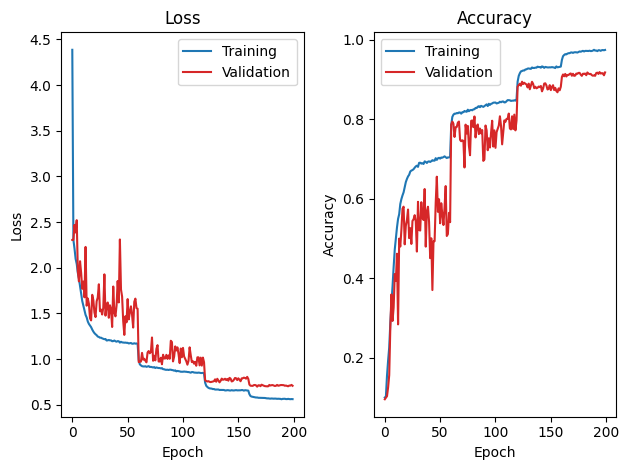

In [ ]:
if __name__ == "__main__":

    """ You can adjust the numbers below """

    EPOCHS = 300  
    BATCH_SIZE = 256  
    LEARNING_RATE = 0.3  
    
    # Reload data with the new batch size
    train_loader, val_loader, test_loader = get_cifar10_loaders(
        batch_size=BATCH_SIZE, 
        split_ratio=0.1
    )
    
    # Create the model
    model = resnet50_cifar10()
    
    # ========== Enable multi-GPU training ==========
    if torch.cuda.device_count() > 1:
        print(f"Detected {torch.cuda.device_count()} GPUs, enabling DataParallel training")
        print(f"Using GPU devices: {[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]}")
        model = nn.DataParallel(model, device_ids=[0, 1])  # Use GPU 0 and 1
    else:
        print(f"Only 1 GPU detected, using single-GPU training")
    
    model = model.to(DEFAULT_DEVICE)
    
    print(f"\n========== Training Configuration ==========")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")
    print(f"================================\n")
    
    # Start training
    train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

### Model Testing

Evaluating: 100%|██████████| 157/157 [00:05<00:00, 29.15it/s]


Test Accuracy: 95.47% | Loss: 0.1838
Confusion matrix saved to ./results/confusion_matrix-2.png


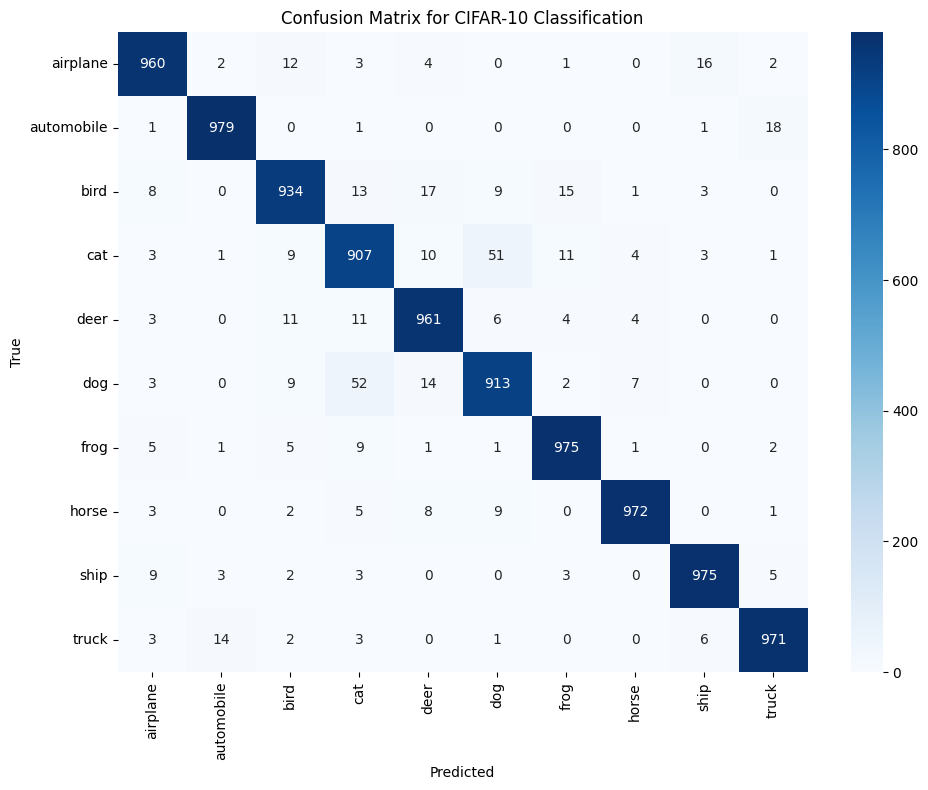

In [10]:
if __name__ == "__main__":

    ##### YOUR CODE HERE #####
    # Implement your criterion
    # 定义损失函数：交叉熵损失（与训练时保持一致）
    criterion = nn.CrossEntropyLoss()

    model = resnet50_cifar10().to(DEFAULT_DEVICE)
    model = load_model(model, "./weights/best_resnet50_cifar10.pth", verbose=False)
    avg_loss, test_acc, conf_matrix = evaluate(model, test_loader, criterion)
    print(f"Test Accuracy: {test_acc:.2f}% | Loss: {avg_loss:.4f}")
    plot_confusion_matrix(conf_matrix, filename="./results/confusion_matrix.png")

## Post-Training Quantization (PTQ)
### Implement Quantization Function

In [ ]:
class CusQuantObserver(tq.MinMaxObserver):
    """
    Observer module for your customized customize quantization scheme.
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        ##### YOUR CODE HERE #####
        """
        將 scale 近似為 2 的冪次，以便使用位移操作加速量化/反量化。
        
        原理：
        - 找到最接近 scale 的 2 的冪次：2^n
        - 透過 log2(scale) 計算指數 n
        - 限制 n 的範圍在 [-max_shift_amount, max_shift_amount] 內，防止溢出
        
        Args:
            scale: 原始 scale 值
            max_shift_amount: 最大位移量（防止溢出）
        
        Returns:
            近似後的 scale（2 的冪次）
        """
        if scale <= 0:
            return scale
        
        # 計算 log2(scale)，得到指數 n
        # 使用 log2 找到最接近的 2 的冪次
        n = math.log2(scale)
        
        # 將 n 四捨五入到最近的整數
        n_rounded = round(n)
        
        # 限制 n 的範圍，防止溢出
        # 左移（n > 0）會增加 scale，右移（n < 0）會減小 scale
        n_clamped = max(-max_shift_amount, min(max_shift_amount, n_rounded))
        
        # 計算近似後的 scale = 2^n_clamped
        approximated_scale = 2.0 ** n_clamped
        
        return approximated_scale


    def calculate_qparams(self):
        """Calculates the quantization parameters with scale."""
        min_val, max_val = self.min_val.item(), self.max_val.item()

        """ Calculate zero_point as in the base class """
        ##### YOUR CODE HERE #####
        # 取得量化範圍
        # 對於 quint8: [0, 255]，對於 qint8: [-128, 127]
        if self.dtype == torch.quint8:
            qmin, qmax = 0, 255
        elif self.dtype == torch.qint8:
            qmin, qmax = -128, 127
        else:
            qmin, qmax = 0, 255  # 預設值
        
        # 根據量化方案（symmetric 或 asymmetric）計算 scale 和 zero_point
        if self.qscheme == torch.per_tensor_symmetric:
            # symmetric 量化: zero_point = 0
            # scale = max(|min_val|, |max_val|) / qmax
            max_abs = max(abs(min_val), abs(max_val))
            if max_abs == 0:
                scale = 1.0
            else:
                scale = max_abs / float(qmax)
            zero_point = 0
        else:
            # asymmetric 量化
            # scale = (max_val - min_val) / (qmax - qmin)
            if max_val == min_val:
                scale = 1.0
            else:
                scale = (max_val - min_val) / float(qmax - qmin)
            
            # zero_point = qmin - round(min_val / scale)
            zero_point = qmin - round(min_val / scale)
            # 確保 zero_point 在量化範圍內
            zero_point = max(qmin, min(qmax, zero_point))
        
        # 使用 scale_approximate 近似 scale（加速量化/反量化）
        scale = self.scale_approximate(scale)
        
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        return scale, zero_point

    def extra_repr(self):
        return f"min_val={self.min_val}, max_val={self.max_val}, scale=CustomQConfig"


class CustomQConfig(Enum):
    CusQuant = tq.QConfig(
        activation=CusQuantObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=CusQuantObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None

### Evaluate Quantized Model

In [8]:
def test_performance(model_fp32, model_int8, dataloader, criterion,
                     is_ptq: bool = True,
                     fp32_file="./weights/best_resnet50_cifar10.pth",
                     int8_file="./weights/PTQ_resnet50_cifar10.pth"
                    ):
    
    device_fp32 = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_int8 = 'cpu'

    model_fp32.to(device_fp32)
    model_int8.to(device_int8)


    # ----- Test accuracy & loss -----
    print("Evaluating FP32 model...")
    loss_fp32, acc_fp32, _ = evaluate(model_fp32, dataloader, criterion, device=device_fp32)
    print(f"[FP32] Loss: {loss_fp32:.4f}, Accuracy: {acc_fp32:.2f}%")

    print("Evaluating INT8 model...")
    loss_int8, acc_int8, _ = evaluate(model_int8, dataloader, criterion, device=device_int8)
    if is_ptq:
        print(f"[PTQ INT8] Loss: {loss_int8:.4f}, Accuracy: {acc_int8:.2f}%")
    else:
        print(f"[QAT INT8] Loss: {loss_int8:.4f}, Accuracy: {acc_int8:.2f}%")


    # ----- Test latency -----
    model_fp32.to('cpu')
    dummy_input = torch.randn(1, 3, 32, 32).to('cpu')

    # FP32
    t0 = time.time()
    with torch.no_grad():
        for _ in range(1000):
            _ = model_fp32(dummy_input)
    t1 = time.time()
    fp32_time = (t1 - t0) / 1000

    # INT8
    t0 = time.time()
    with torch.no_grad():
        for _ in range(1000):
            _ = model_int8(dummy_input)
    t1 = time.time()
    int8_time = (t1 - t0) / 1000

    if is_ptq:
        print(f"[Latency] FP32: {fp32_time*1000:.3f} ms | PTQ INT8: {int8_time*1000:.3f} ms")
    else:
        print(f"[Latency] FP32: {fp32_time*1000:.3f} ms | QAT INT8: {int8_time*1000:.3f} ms")
    print(f"[Speedup] ~{fp32_time/int8_time:.2f}x faster")


    # ----- Compare file size ----- 
    if os.path.exists(fp32_file) and os.path.exists(int8_file):
        size_fp32 = os.path.getsize(fp32_file) / 1e6
        size_int8 = os.path.getsize(int8_file) / 1e6
        if is_ptq:
            print(f"[File size] FP32: {size_fp32:.2f} MB | PTQ INT8: {size_int8:.2f} MB")
        else:
            print(f"[File size] FP32: {size_fp32:.2f} MB | QAT INT8: {size_int8:.2f} MB")
        print(f"[Compression] ~{size_fp32/size_int8:.2f}x smaller")
    else:
        print("Warning: model files not found. Skipping file size comparison.")

### Run PTQ Workflow

In [9]:
def calibrate(model, loader, device= 'cpu'):
    """
    Run one pass of calibration on the dataset to collect statistics 
    for quantization (e.g., min/max values of activations).
    
    Args:
        model (nn.Module): The model prepared for quantization.
        loader (DataLoader): Data loader for calibration dataset.
        device (str): Device to run calibration on.
    """
    ##### YOUR CODE HERE #####
    # 校准：运行模型收集激活值的统计信息（min/max）
    # 这些统计信息将用于计算量化参数（scale 和 zero_point）
    
    model.eval()  # 设置为评估模式
    model.to(device)
    
    with torch.no_grad():
        # 遍历校准数据集，收集激活值的统计信息
        for images, _ in tqdm(loader, desc="Calibrating"):
            images = images.to(device)
            # 前向传播，Observer 会自动收集 min/max 值
            _ = model(images)


def ptq_quantization():
    """
    Perform Post-Training Quantization (PTQ) on the trained ResNet-50 model.
    
    Steps:
        1. Load CIFAR-10 validation set
        2. Load trained FP32 model
        3. Fuse model layers
        4. Prepare model for PTQ
        5. Calibrate using validation data
        6. Convert model to INT8
        7. Save quantized model
    Returns:
        model_int8 (nn.Module): The INT8 quantized model after PTQ
    """
    # 1. Data
    _, val_loader, _ = get_cifar10_loaders(batch_size=64)

    # 2. Load model (FP32 baseline)
    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_fp32 = load_model(resnet50_cifar10(), fp32_checkpoint)

    ##### YOUR CODE HERE #####
    # 3. Fuse layers
    # 融合 Conv-BN-ReLU 层，提升量化效率和准确率
    model_fp32.eval()
    model_fp32.to('cpu')  # 量化需要在 CPU 上进行
    model_fp32.fuse_model()
    
    # 4. Prepare PTQ
    # 设置量化配置（使用自定义的 CustomQConfig 或默认配置）
    # 根据量化后端选择配置（fbgemm 用于 x86，qnnpack 用于 ARM）
    backend = torch.backends.quantized.engine
    # 可以选择使用自定义配置：CustomQConfig.CusQuant.value
    # 或使用默认配置：tq.get_default_qconfig(backend)
    model_fp32.qconfig = tq.get_default_qconfig(backend)  # 或使用 CustomQConfig.CusQuant.value
    
    # 准备模型进行量化（插入 Observer 来收集统计信息）
    model_prepared = tq.prepare(model_fp32)
    
    # 5. Calibrate
    # 在校准数据集上运行模型，收集激活值的 min/max 统计信息
    calibrate(model_prepared, val_loader, device='cpu')
    
    # 6. Convert to INT8
    # 将模型转换为 INT8 量化模型（使用收集到的统计信息计算量化参数）
    model_int8 = tq.convert(model_prepared)

    # 7. Save INT8 model
    save_model(model_int8, "./weights/PTQ_resnet50_cifar10.pth", existed="overwrite")
    
    return model_int8

### Compare FP32 vs Quantized Results

In [10]:
if __name__ == "__main__":
    model_int8 = ptq_quantization()

    ##### YOUR CODE HERE #####
    # Implement your criterion
    # 定义损失函数：交叉熵损失（与训练时保持一致）
    criterion = nn.CrossEntropyLoss()
    
    # 加载测试数据集
    _, _, test_loader = get_cifar10_loaders(batch_size=64)

    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_baseline = load_model(resnet50_cifar10(), fp32_checkpoint, verbose=True)
    test_performance(model_baseline, model_int8, test_loader, criterion, is_ptq=True)

Files already downloaded and verified
Files already downloaded and verified
Model loaded from ./weights/best_resnet50_cifar10.pth (94.399914 MB)


Calibrating: 100%|██████████| 79/79 [01:16<00:00,  1.03it/s]


Model saved at ./weights/PTQ_resnet50_cifar10.pth (24.115272 MB)
Files already downloaded and verified
Files already downloaded and verified
Model loaded from ./weights/best_resnet50_cifar10.pth (94.399914 MB)
Evaluating FP32 model...


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 38.99it/s]


[FP32] Loss: 0.1838, Accuracy: 95.47%
Evaluating INT8 model...


Evaluating: 100%|██████████| 157/157 [00:35<00:00,  4.47it/s]


[PTQ INT8] Loss: 0.1845, Accuracy: 95.42%
[Latency] FP32: 18.276 ms | PTQ INT8: 9.563 ms
[Speedup] ~1.91x faster
[File size] FP32: 94.40 MB | PTQ INT8: 24.12 MB
[Compression] ~3.91x smaller


## Quantization-Aware Training (QAT)
### Run QAT Workflow

Files already downloaded and verified
Files already downloaded and verified
Model loaded from ./weights/best_resnet50_cifar10.pth (94.399914 MB)


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.36it/s]


Epoch 1 | Train Loss: 0.6638 | Train Acc: 72.69% | Val Loss: 0.4255 | Val Acc: 94.86%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.772707 MB)


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.16it/s]


Epoch 2 | Train Loss: 0.6390 | Train Acc: 74.16% | Val Loss: 0.4088 | Val Acc: 95.26%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.772707 MB)


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]


Epoch 3 | Train Loss: 0.6124 | Train Acc: 74.40% | Val Loss: 0.4145 | Val Acc: 94.78%


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.21it/s]


Epoch 4 | Train Loss: 0.6331 | Train Acc: 71.60% | Val Loss: 0.4121 | Val Acc: 95.30%
Model saved at ./weights/QAT_resnet50_cifar10.pth (94.772707 MB)


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.33it/s]


Epoch 5 | Train Loss: 0.5916 | Train Acc: 74.52% | Val Loss: 0.4114 | Val Acc: 95.02%
Plot saved at ./results/QAT_loss_accuracy.png
Model saved at ./weights/QAT_resnet50_cifar10.pth (24.115272 MB)
Files already downloaded and verified
Files already downloaded and verified
Evaluating FP32 model...


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 44.81it/s]


[FP32] Loss: 0.1838, Accuracy: 95.47%
Evaluating INT8 model...


Evaluating: 100%|██████████| 157/157 [00:34<00:00,  4.49it/s]


[QAT INT8] Loss: 0.1902, Accuracy: 95.52%
[Latency] FP32: 20.718 ms | QAT INT8: 9.933 ms
[Speedup] ~2.09x faster
[File size] FP32: 94.40 MB | QAT INT8: 24.12 MB
[Compression] ~3.91x smaller


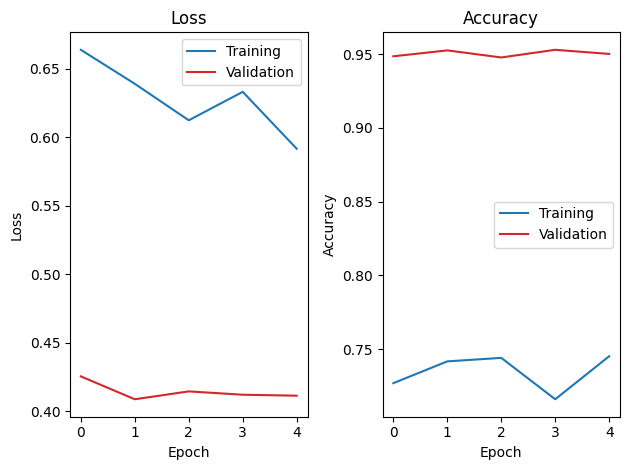

In [14]:
def qat_quantization():
    """
    Run Quantization-Aware Training (QAT) workflow on ResNet-50 for CIFAR-10.
    
    Steps:
        0. Prepare CIFAR-10 dataloaders
        1. Load pretrained FP32 model
        2. Fuse model layers
        3. Assign QAT qconfig
        4. Prepare model for QAT
        5. Train with QAT
        6. Convert to INT8 model
        7. Save quantized model
    Returns:
        model_int8 (nn.Module): The INT8 quantized model after QAT
    """
    # 1. Data
    train_loader, val_loader, test_loader = get_cifar10_loaders(batch_size=64)

    # 2. Load model (FP32 baseline)
    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_fp32 = load_model(resnet50_cifar10(), fp32_checkpoint)

    ##### YOUR CODE HERE #####
    # 3. Fuse layers before QAT
    # 融合 Conv-BN-ReLU 层，提升量化效率和准确率
    model_fp32.eval()
    model_fp32.to('cpu')  # 量化需要在 CPU 上进行
    model_fp32.fuse_model()
    
    # 4. Set qconfig to enable QAT
    # QAT 使用专门的 QAT qconfig（与 PTQ 不同）
    # QAT qconfig 会在训练时模拟量化，让模型适应量化误差
    backend = torch.backends.quantized.engine
    # 可以使用默认 QAT 配置或自定义配置
    model_fp32.qconfig = tq.get_default_qat_qconfig(backend)  # 或使用 CustomQConfig.CusQuant.value
    
    # 5. Prepare model
    # 准备模型进行 QAT（插入 FakeQuantize 模块来模拟量化）
    # 重要：prepare_qat 要求模型处于训练模式（training mode）
    model_fp32.train()  # 设置为训练模式（QAT 需要）
    model_qat = tq.prepare_qat(model_fp32)

    # 6. Run QAT training
    # Use train_model(is_qat=True, ...)
    # QAT 训练：在训练过程中模拟量化，让模型学习适应量化误差
    # 通常只需要训练几个 epochs（3-10），因为模型已经预训练好了
    model_qat = model_qat.to(DEFAULT_DEVICE)  # 训练时可以使用 GPU
    model_qat = train_model(
        model_qat, 
        train_loader, 
        val_loader, 
        epochs=5,  # QAT 通常只需要少量 epochs
        lr=0.0001,  # 使用较小的学习率（fine-tuning）
        is_qat=True,  # 标记为 QAT 训练
        device=DEFAULT_DEVICE
    )

    # 7. Convert to INT8
    # QAT 训练完成后，将模型转换为真正的 INT8 量化模型
    model_qat.eval()
    model_qat.to('cpu')  # 转换需要在 CPU 上进行
    model_int8 = tq.convert(model_qat)

    # 8. Save INT8 model
    save_model(model_int8, "./weights/QAT_resnet50_cifar10.pth", existed="overwrite")

    return model_int8

if __name__ == "__main__":
    model_int8 = qat_quantization()

    ##### YOUR CODE HERE #####
    # Implement your criterion
    # 定义损失函数：交叉熵损失（与训练时保持一致）
    criterion = nn.CrossEntropyLoss()
    
    # 加载测试数据集
    _, _, test_loader = get_cifar10_loaders(batch_size=64)

    fp32_checkpoint = "./weights/best_resnet50_cifar10.pth"
    model_baseline = load_model(resnet50_cifar10(), fp32_checkpoint, verbose=False)
    test_performance(model_baseline, model_int8, test_loader, criterion, is_ptq=False,
                    fp32_file=fp32_checkpoint, int8_file="./weights/QAT_resnet50_cifar10.pth")